## Pythonライブラリ「RDFLib」によるRDF利用プログラミング

このノートブックは一般公開イベント  
[ナレッジグラフ推論チャレンジ2021「技術勉強会」 ～ナレッジグラフ利用技術の基礎と推論/説明への活用例～](https://kgrc2021ws.peatix.com/)  
において「ナレッジグラフ／ＬＯＤ利用技術の入門（後編）」の説明に使用されるPythonチュートリアルです。  
スライドはこちらからご確認ください→[KGRC-WS-2021_0830_GraphDB_python.pdf](https://github.com/KnowledgeGraphJapan/KGRC-ws-2021/blob/main/Section2/KGRC-WS-2021_0830_GraphDB_python.pdf)  
※Google Colabではご自身のGoogle Driveにコピーしてチュートリアルを進めてください。

# 【準備】必要なライブラリのインストール

In [ ]:
!pip install rdflib

In [ ]:
!pip install SPARQLWrapper

In [ ]:
!pip install pydotplus
!pip install graphviz

In [ ]:
#日本語フォント
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


インポート

In [ ]:
from rdflib import *
from SPARQLWrapper import SPARQLWrapper, JSON

# ナレッジグラフ（RDF）の作成

## 作成するナレッジグラフの例

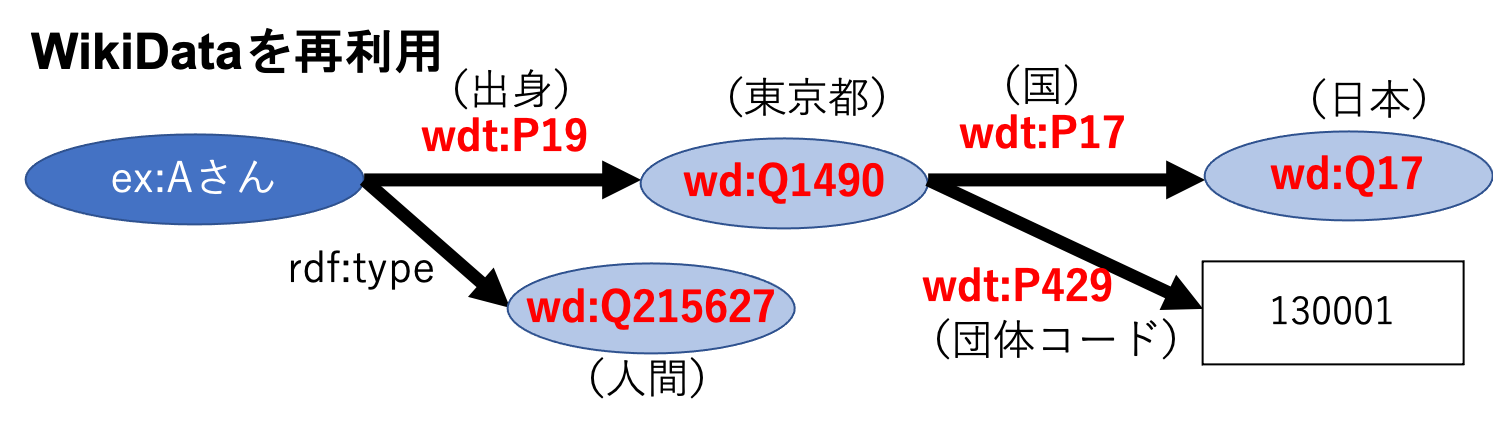

## 名前空間（Namespace）の定義

In [ ]:
base = Namespace("http://example.org/instance/") #独自に作るリソースのURI
wd = Namespace("http://www.wikidata.org/entity/") #wikidataのリソース
wdt = Namespace("http://www.wikidata.org/prop/direct/") #wikidataのプロパティ

## リソース、トリプルを追加

In [ ]:
#空のグラフ
g = Graph()

#prefixのバインド
g.bind("ex", base)
g.bind("wd", wd)
g.bind("wdt", wdt)

#リソースを作成
a_san = base["Aさん"] #リソースのURIは「http://example.org/instance/Aさん」となる
person = wd["Q215627"]

#トリプルを作成（とりあえず一つだけ）
g.add((a_san, RDF.type, person)) #RDF, RDFS, OWLなどの標準化されている語彙は定義せずとも利用可能

ナレッジグラフ（RDF）をシリアライズして出力

In [ ]:
#Turtle形式で出力
print(g.serialize(format="turtle")) #turtle, nt, xmlなど

@prefix ex: <http://example.org/instance/> .
@prefix wd: <http://www.wikidata.org/entity/> .

ex:Aさん a wd:Q215627 .




他のトリプルも追加

In [ ]:
tokyo = wd["Q1490"]
japan = wd["Q17"]
g.add((a_san, wdt["P19"], tokyo))
g.add((tokyo, wdt["P17"], japan))
g.add((tokyo, wdt["P429"], Literal("130001"))) #リテラル作成はLiteral(値, datatype=データ型). データ型はXSD.decimalなど

## エクスポート、インポート

ファイルとして出力

In [ ]:
g.serialize(destination="example.ttl", format="turtle") #turtle, nt, xmlなど

ファイルのロード

In [ ]:
#先程作成したttlファイルを読み込む
load_g = Graph() 
load_g.parse("example.ttl", format='turtle')
print(load_g.serialize(format="turtle")) #turtleを標準出力

@prefix ex: <http://example.org/instance/> .
@prefix wd: <http://www.wikidata.org/entity/> .
@prefix wdt: <http://www.wikidata.org/prop/direct/> .

ex:Aさん a wd:Q215627 ;
    wdt:P19 wd:Q1490 .

wd:Q1490 wdt:P17 wd:Q17 ;
    wdt:P429 "130001" .




## ナレッジグラフの可視化

参考: [https://stackoverflow.com/a/61483971](https://stackoverflow.com/a/61483971)

In [ ]:
#必要ライブラリのインポート
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

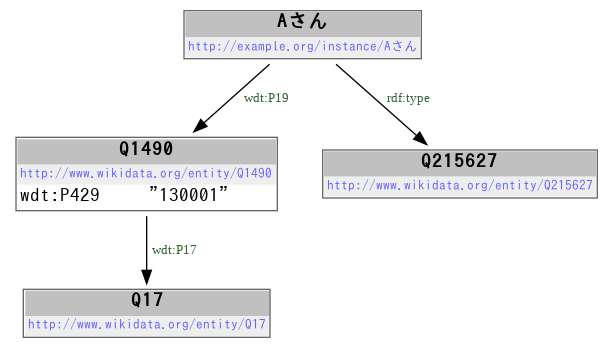

In [ ]:
#先程作成したttlファイルを読み込む
load_g = Graph() 
load_g.parse("example.ttl", format='turtle')

stream = io.StringIO()
rdf2dot(load_g, stream, opts = {display})
dg = pydotplus.graph_from_dot_data(stream.getvalue())
png = dg.create_png()
display(Image(png))

# SPARQLによるナレッジグラフの利用

## 外部SPARQLエンドポイントを利用

### Wikidata

In [ ]:
queryString = """
#アカデミー賞とノーベル賞を両方受賞した人
SELECT DISTINCT ?Person ?PersonLabel ?NobelPrizeLabel ?AcademyAwardLabel WHERE {
  ?NobelPrize wdt:P279?/wdt:P31? wd:Q7191 .    # <- subtypes of nobel prize
  ?AcademyAward wdt:P279?/wdt:P31? wd:Q19020 . # <- subtypes of academy award
  ?Person wdt:P166? ?NobelPrize .              # <- people awarded a nobel prize
  ?Person wdt:P166? ?AcademyAward .            # <- people awarded an academy award
  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" .
  }
}
"""

endpointURI = "https://query.wikidata.org/sparql" # wikidataのSPARQLエンドポイント
sparql = SPARQLWrapper(endpointURI)
sparql.setQuery(queryString)
sparql.setReturnFormat(JSON)

json = sparql.query().convert()
bindings = json['results']['bindings']
results = bindings
for entity in results:
  print(entity["Person"]["value"] + " | " + entity["PersonLabel"]["value"] + " | " + entity["NobelPrizeLabel"]["value"] + " | " + entity["AcademyAwardLabel"]["value"])

http://www.wikidata.org/entity/Q19185 | George Bernard Shaw | Nobel Prize in Literature | Academy Award for Best Writing, Adapted Screenplay
http://www.wikidata.org/entity/Q392 | Bob Dylan | Nobel Prize in Literature | Academy Award for Best Original Song


### DBpedia Japanese

In [28]:
queryString = """
#全国の地域限定ゆるキャラ(10件まで)
SELECT DISTINCT ?mascot ?name
WHERE {
  ?areamascots skos:broader <http://ja.dbpedia.org/resource/Category:地域限定のマスコット> ;
    rdfs:label ?areaname .
  ?mascot dbo:wikiPageWikiLink ?areamascots ;
    rdfs:label ?name.
} limit 10
"""

"""
DBpedia JapaneseのSPARQLエンドポイント
http://ja.dbpedia.org/sparql
サーバ負荷軽減のため実演時に手入力
"""

endpointURI = "" # DBpedia JapaneseのSPARQLエンドポイント
sparql = SPARQLWrapper(endpointURI)
sparql.setQuery(queryString)
sparql.setReturnFormat(JSON)

json = sparql.query().convert()
bindings = json['results']['bindings']
results = bindings
for entity in results:
  print(entity["mascot"]["value"] + " | " + entity["name"]["value"])

http://ja.dbpedia.org/resource/DB.スターマン | DB.スターマン
http://ja.dbpedia.org/resource/Qごろ〜 | Qごろ〜
http://ja.dbpedia.org/resource/SUNちゃん_(琉球放送) | SUNちゃん (琉球放送)
http://ja.dbpedia.org/resource/あいさいさん | あいさいさん
http://ja.dbpedia.org/resource/あかべぇ | あかべぇ
http://ja.dbpedia.org/resource/あつべえ | あつべえ
http://ja.dbpedia.org/resource/いなぼう | いなぼう
http://ja.dbpedia.org/resource/いなピョン | いなピョン
http://ja.dbpedia.org/resource/うすかわくん | うすかわくん
http://ja.dbpedia.org/resource/えすまる | えすまる


### ナレッジグラフ推論チャレンジ

[ナレッジグラフ推論チャレンジ](https://challenge.knowledge-graph.jp/)のSPARQLエンドポイントに対してSPARQLクエリを実行して結果を取得

In [ ]:
queryString = """
PREFIX kgc: <http://kgc.knowledge-graph.jp/ontology/kgc.owl#>
SELECT DISTINCT *
FROM <http://kgc.knowledge-graph.jp/data/SpeckledBand>
#FROM <http://kgc.knowledge-graph.jp/data/DancingMen>
#FROM <http://kgc.knowledge-graph.jp/data/ACaseOfIdentity>
#FROM <http://kgc.knowledge-graph.jp/data/DevilsFoot>
#FROM <http://kgc.knowledge-graph.jp/data/CrookedMan>
#FROM <http://kgc.knowledge-graph.jp/data/AbbeyGrange>
#FROM <http://kgc.knowledge-graph.jp/data/SilverBlaze>
#FROM <http://kgc.knowledge-graph.jp/data/ResidentPatient>
WHERE {
  # 小説「まだらの紐」から、シーンIDとそのシーンの述語を10件まで取得する
  ?s kgc:hasPredicate ?o .
} limit 10
"""

"""
ナレッジグラフ推論チャレンジのエンドポイント
http://kg.hozo.jp/fuseki/kgrc2020v2/sparql
サーバ負荷軽減のため実演時に手入力
"""

endpointURI = ""
sparql = SPARQLWrapper(endpointURI)
sparql.setQuery(queryString)
sparql.setReturnFormat(JSON)

json = sparql.query().convert()
bindings = json['results']['bindings']
results = bindings
for entity in results:
  print(entity["s"]["value"] + " | " + entity["o"]["value"])

http://kgc.knowledge-graph.jp/data/SpeckledBand/8 | http://kgc.knowledge-graph.jp/data/predicate/live
http://kgc.knowledge-graph.jp/data/SpeckledBand/17 | http://kgc.knowledge-graph.jp/data/predicate/live
http://kgc.knowledge-graph.jp/data/SpeckledBand/26 | http://kgc.knowledge-graph.jp/data/predicate/live
http://kgc.knowledge-graph.jp/data/SpeckledBand/33 | http://kgc.knowledge-graph.jp/data/predicate/live
http://kgc.knowledge-graph.jp/data/SpeckledBand/40 | http://kgc.knowledge-graph.jp/data/predicate/live
http://kgc.knowledge-graph.jp/data/SpeckledBand/41 | http://kgc.knowledge-graph.jp/data/predicate/live
http://kgc.knowledge-graph.jp/data/SpeckledBand/42 | http://kgc.knowledge-graph.jp/data/predicate/live
http://kgc.knowledge-graph.jp/data/SpeckledBand/111 | http://kgc.knowledge-graph.jp/data/predicate/live
http://kgc.knowledge-graph.jp/data/SpeckledBand/77 | http://kgc.knowledge-graph.jp/data/predicate/say
http://kgc.knowledge-graph.jp/data/SpeckledBand/261 | http://kgc.knowledge

## ローカルのトリプルストアを利用

### 事前準備

**※本チュートリアルをGoogle ColabではなくローカルのJupyterで実行している場合は下記の準備は不要**

参考：[Google Colaboratory を自分のマシンで走らせる](https://www.kabuku.co.jp/developers/run_google_colaboratory_notebooks_on_local_machine)

（Jupyterをインストールしていない場合）ローカルマシンにJupyterをインストール
```
$ pip install jupyter
```

拡張機能jupyter_http_over_wsをいれる
```
$ pip install jupyter_http_over_ws
$ jupyter serverextension enable --py jupyter_http_over_ws
```

Jupyterの起動
```
$ jupyter notebook \
  --NotebookApp.allow_origin='https://colab.research.google.com' \
  --port=8888
```

Google Colab画面右上▼から「ローカルランタイムに接続」 を選択。  
「バックエンドURL」欄にJupyter起動時に発行されるアクセスURLを入力  
```
http://localhost:8888/?token={トークン}
```
以上で準備は完了

### GraphDBを利用

事前に[GraphDB](https://www.ontotext.com/products/graphdb/)無償版をインストールし、リポジトリを作成しておく必要があります。  
今回はkgrc2021という名前のリポジトリを作成し、ナレッジグラフ推論チャレンジのRDFデータを格納済み。

In [ ]:
from rdflib import *
from SPARQLWrapper import SPARQLWrapper, JSON

queryString = """
PREFIX kgc: <http://kgc.knowledge-graph.jp/ontology/kgc.owl#>
SELECT DISTINCT *
FROM <http://kgc.knowledge-graph.jp/data/SpeckledBand>
#FROM <http://kgc.knowledge-graph.jp/data/DancingMen>
#FROM <http://kgc.knowledge-graph.jp/data/ACaseOfIdentity>
#FROM <http://kgc.knowledge-graph.jp/data/DevilsFoot>
#FROM <http://kgc.knowledge-graph.jp/data/CrookedMan>
#FROM <http://kgc.knowledge-graph.jp/data/AbbeyGrange>
#FROM <http://kgc.knowledge-graph.jp/data/SilverBlaze>
#FROM <http://kgc.knowledge-graph.jp/data/ResidentPatient>
WHERE {
  # 小説「まだらの紐」から、シーンIDとそのシーンの述語を10件まで取得する
  ?s kgc:hasPredicate ?o .
} limit 10
"""

# GraphDBのデフォルトのポートは7200.
# http://localhost:7200/repositories/{リポジトリ名} がSPARQLエンドポイントURIとなる
sparql = SPARQLWrapper("http://localhost:7200/repositories/kgrc2021")
sparql.setQuery(queryString)
sparql.setQuery(queryString)
sparql.setReturnFormat(JSON)

#認証が必要な場合
#sparql.setHTTPAuth(BASIC)
#sparql.setCredentials('user', 'password')

json = sparql.query().convert()
bindings = json['results']['bindings']
results = bindings
for entity in results:
  print(entity["s"]["value"] + " | " + entity["o"]["value"])

URLError: ignored

# ライセンス

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="クリエイティブ・コモンズ・ライセンス" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><a xmlns:cc="http://creativecommons.org/ns#" href="https://github.com/KnowledgeGraphJapan/KGRC-ws-2021/tree/main/Section2" property="cc:attributionName" rel="cc:attributionURL">人工知能学会セマンティックウェブとオントロジー研究会企画委員</a> 作『<span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Pythonライブラリ「RDFLib」によるRDF利用プログラミング</span>』は<a rel="license" href="http://creativecommons.org/licenses/by/4.0/">クリエイティブ・コモンズ 表示 4.0 国際 ライセンス</a>で提供されています。